In [1]:
from pylearn2.utils.serial import load as load_model
from pylearn2.gui.get_weights_report import get_weights_report
import numpy as np
import matplotlib.pyplot as plt
import os.path
import io
from IPython.display import display, Image
import neukrill_net.image_directory_dataset as idd
import neukrill_net.encoding as enc
import theano as th
import PIL.Image as img
%matplotlib inline

Using gpu device 0: Tesla K20c


In [2]:
MODEL_PICKLE_PATH = '${DATA_DIR}/plankton/models/fewer_conv_channels_with_dropout_resume.pkl'
IM_HEIGHT = 64
IM_WIDTH = 64
NORMALISE_MU = 0.954849097973459
NORMALISE_SIGMA = 0.14445522859064192

In [4]:
model = load_model(os.path.expandvars('${DATA_DIR}/plankton/models/fewer_conv_channels_with_dropout_resume.pkl'))
dataset = idd.ListDataset(transformer=lambda x: None, settings_path='../settings.json', 
                          run_settings_path='../run_settings/replicate_8aug.json', 
                          training_set_mode='test', force=True,
                          prepreprocessing={'resize' : [IM_HEIGHT, IM_WIDTH], 'resize_order': 1,
                                            "normalise":{"global_or_pixel":"global", 
                                                         "mu":NORMALISE_MU, 
                                                         "sigma":NORMALISE_SIGMA}})

## Model summary

In [3]:
print('## Model structure summary\n')
print(model)
params = model.get_params() 
n_params = {p.name : p.get_value().size for p in params}
total_params = sum(n_params.values())
print('\n## Number of parameters\n')
print('  ' + '\n  '.join(['{0} : {1} ({2:.1f}%)'.format(k, v, 100.*v/total_params) 
                          for k, v in sorted(n_params.items(), key=lambda x: x[0])]))
print('\nTotal : {0}'.format(total_params))

## Model structure summary

h1
	Input space: Conv2DSpace(shape=(64, 64), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32)
	Total input dimension: 4096
h2
	Input space: Conv2DSpace(shape=(34, 34), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 55488
h3
	Input space: Conv2DSpace(shape=(18, 18), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 15552
h4
	Input space: Conv2DSpace(shape=(10, 10), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 4800
h5
	Input space: VectorSpace(dim=512, dtype=float32)
	Total input dimension: 512
y
	Input space: VectorSpace(dim=512, dtype=float32)
	Total input dimension: 512

## Number of parameters

  h1_W : 1200 (0.0%)
  h1_b : 221952 (7.1%)
  h2_W : 20736 (0.7%)
  h2_b : 62208 (2.0%)
  h3_W : 20736 (0.7%)
  h3_b : 19200 (0.6%)
  h4_W : 2457600 (78.5%)
  h4_b : 512 (0.0%)
  h5_W : 262144 (8.4%)
  h5_b : 512 (0.0%)
  softmax_W : 61952 (2.0%)
  softmax_b : 121 (0.

## Train and valid set NLL trace 

Minimum validation set NLL 0.802239239216


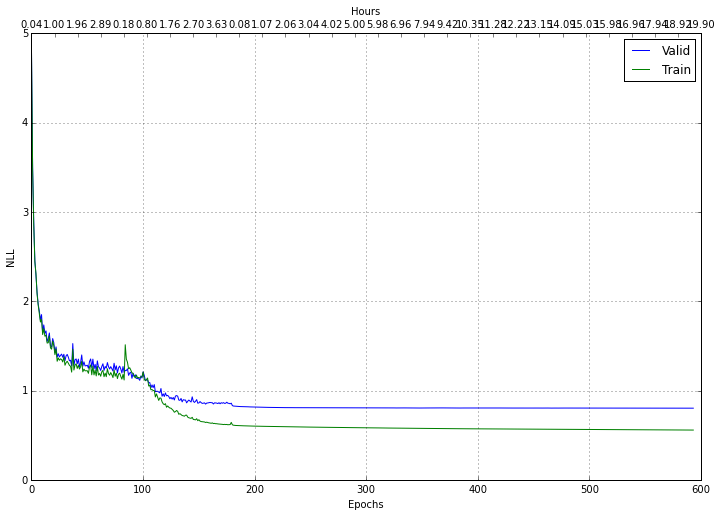

In [4]:
tr = np.array(model.monitor.channels['valid_y_y_1_nll'].time_record) / 3600.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.plot(model.monitor.channels['valid_y_y_1_nll'].val_record)
ax1.plot(model.monitor.channels['train_y_y_1_nll'].val_record)
ax1.set_xlabel('Epochs')
ax1.legend(['Valid', 'Train'])
ax1.set_ylabel('NLL')
ax1.set_ylim(0., 5.)
ax1.grid(True)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,tr.shape[0],20))
ax2.set_xticklabels(['{0:.2f}'.format(t) for t in tr[::20]])
ax2.set_xlabel('Hours')
print("Minimum validation set NLL {0}".format(min(model.monitor.channels['valid_y_y_1_nll'].val_record)))

## Visualising first layer weights

smallest enc weight magnitude: 0.00015657748736
mean enc weight magnitude: 0.146010577679
max enc weight magnitude: 0.823297262192


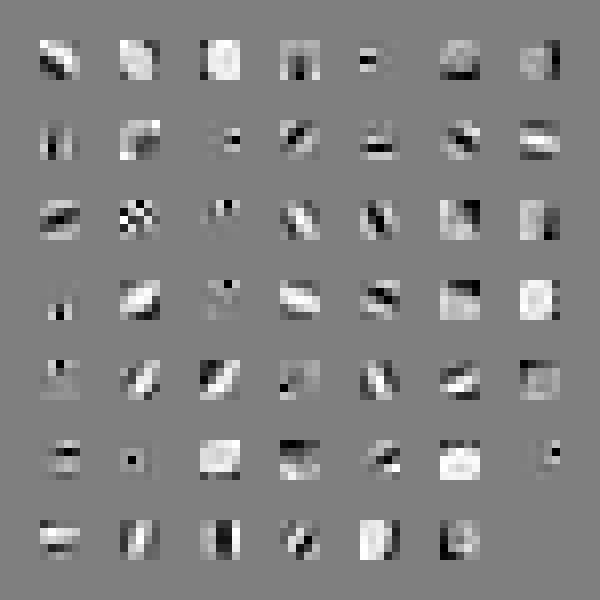

In [13]:
pv = get_weights_report(model=model)
img = pv.get_img()
img = img.resize((8*img.size[0], 8*img.size[1]))
img_data = io.BytesIO()
img.save(img_data, format='png')
display(Image(data=img_data.getvalue(), format='png'))

## Visualising activitations for example test images

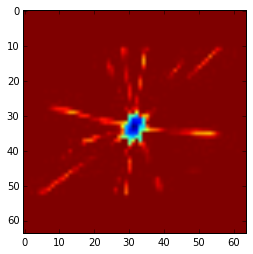

In [5]:
plt.imshow(dataset.X[0])

In [6]:
X = model.get_input_space().make_theano_batch()
Y = model.fprop( X, True )
model_activ_func = th.function([X], Y)

In [49]:
input_arrs = [x.astype(np.float32).reshape(64, 64, 1) for x in dataset.X[:2000:10]]
input_arrs = (np.array(input_arrs) - NORMALISE_MU) / NORMALISE_SIGMA
true_labels = [int(np.where(y)[0]) for y in dataset.y[:2000:10]]
activs = model_activ_func(input_arrs)

In [50]:
def construct_activity_mosaic(layer_activ, pad=1, margin=5, n_rows=None):
    n_channels, w, h = layer_activ.shape
    if n_rows is None:
        n_rows = int(n_channels**0.5)
    n_cols = int((1.*n_channels)/n_rows)
    assert n_rows * n_cols >= n_channels, "n_rows * n_cols ({0}) < n_channels ({1})".format(n_rows*n_cols, n_channels)
    width = n_cols * (w + pad) - pad + 2 * margin
    height = n_rows * (h + pad) - pad + 2 * margin
    mosaic = np.ones((height, width))
    x, y = margin, margin
    r, c = 0, 0
    for i in range(n_channels):
        mosaic[y:y+h, x:x+w] = layer_activ[i].T
        x += w + pad
        c += 1
        if c == n_cols:
            c = 0
            r += 1
            y += h + pad
            x = margin
    return mosaic

In [51]:
n_classes = np.array([0, 121, 38, 16, 7, 4, 2])
class_boundaries = n_classes.cumsum()
hier = enc.get_hierarchy()
classes = sorted([cls for cls in hier[0]])
encs = [enc.get_encoding(cls, hier) for cls in classes]

In [52]:
norm_conv_activs = [activ[:,:,:,:] for activ in activs[:3]]
norm_conv_activs = [activ - activ.min(axis=(2,3))[:,:,None,None] for activ in norm_conv_activs]
norm_conv_activs = [activ / activ.max(axis=(2,3))[:,:,None,None] for activ in norm_conv_activs]
norm_fc_activs = [activ for activ in activs[3:5]]
norm_fc_activs = [activ - activ.min() for activ in norm_fc_activs]
norm_fc_activs = [activ / activ.max() for activ in norm_fc_activs]
softmax_activs = [activs[-1][:,s:e] for s,e in zip(class_boundaries[:-1], class_boundaries[1:])]

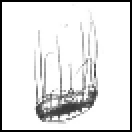

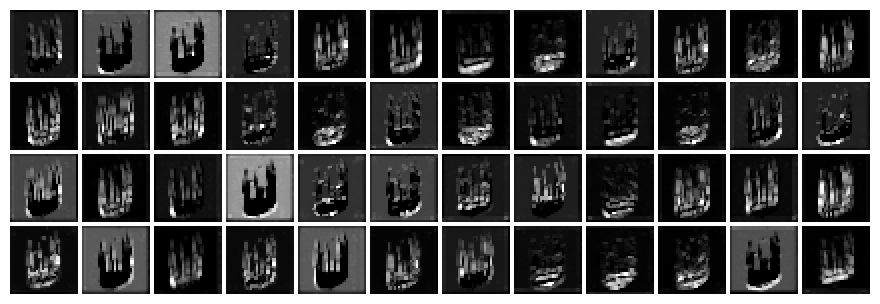

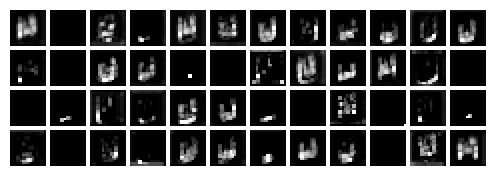

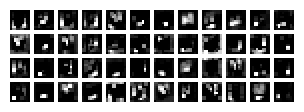

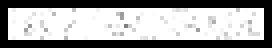

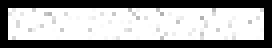

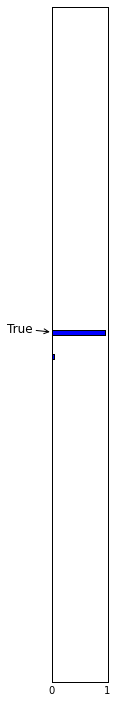

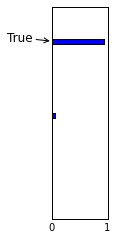

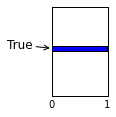

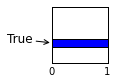

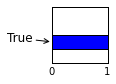

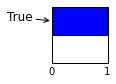

In [58]:
i = 189
scl = 2
true_y = true_labels[i]
true_enc = encs[true_y]
input_arr = input_arrs[i].reshape(1, 64, 64) * NORMALISE_SIGMA + NORMALISE_MU
input_arr = construct_activity_mosaic(1.- input_arr, 0, 1)
input_im = img.fromarray(np.uint8((1-input_arr)*255))
input_im = input_im.resize((scl*input_im.size[0], scl*input_im.size[1]))
input_data = io.BytesIO()
input_im.save(input_data, format='png')
display(Image(data=input_data.getvalue(), format='png'))
for norm_conv_activ in norm_conv_activs:
    mosaic_arr = construct_activity_mosaic(norm_conv_activ[i], 2, 5, 4)
    mosaic_im = img.fromarray(np.uint8((mosaic_arr)*255))
    mosaic_im = mosaic_im.resize((scl*mosaic_im.size[0], scl*mosaic_im.size[1]))
    mosaic_data = io.BytesIO()
    mosaic_im.save(mosaic_data, format='png')
    display(Image(data=mosaic_data.getvalue(), format='png'))
for norm_fc_activ in norm_fc_activs:
    layer_arr = construct_activity_mosaic(norm_fc_activ[i,:].reshape(-1, 8, 1), 0, 2)
    layer_im = img.fromarray(np.uint8((1-layer_arr)*255))
    layer_im = layer_im.resize((2*scl*layer_im.size[0], 2*scl*layer_im.size[1]))
    layer_data = io.BytesIO()
    layer_im.save(layer_data, format='png')
    display(Image(data=layer_data.getvalue(), format='png'))
for j, softmax_activ in enumerate(softmax_activs):
    fig = plt.figure(figsize=(1, max(1,n_classes[j+1]/10.)))
    ax1 = fig.add_subplot(111)
    ax1.barh(np.arange(n_classes[j+1]), softmax_activ[i,:], 1., fill=True)
    ax1.set_xticks([0, 1.])
    ax1.set_yticks([])
    ax1.annotate("True", size=12,
            xy=(0.0, int(np.where(true_enc[j])[0])+0.5), xycoords='data',
            xytext=(-0.8, int(np.where(true_enc[j])[0])+0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
    plt.show()

In [15]:
input_arrs[0].shape

(64, 64, 1)

In [36]:
classes[true_y]

'detritus_other'

In [37]:
np.argmax(softmax_activs[0][i,:])

36

In [38]:
classes[36]

'diatom_chain_string'

In [39]:
true_y

35

In [475]:
softmax_activs[0].shape

(200, 121)

In [23]:
true_y

35

In [43]:
pred_labels = [np.argmax(softmax_activs[0][i,:]) for i in range(200)]

In [44]:
pred_labels == true_labels

False

In [47]:
true_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 3,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 16,
 17,
 17,
 19,
 19,
 19,
 20,
 21,
 22,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 27,
 27,
 28,
 29,
 30,
 32,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 39,
 40,
 41,
 42,
 42,
 42,
 42,
 43,
 43,
 43,
 43,
 43,
 44,
 46,
 47,
 49,
 49,
 49,
 49,
 49,
 49,
 52,
 53,
 54,
 57,
 58,
 59,
 60,
 60,
 63,
 64,
 65,
 65,
 65,
 66,
 67,
 68,
 68,
 68,
 68,
 68,
 69,
 69,
 70,
 70,
 71,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 73,
 74,
 77,
 79,
 80,
 81,
 81,
 82]